In [ ]:
import numpy as np

image_dateset = 'datasets/unlabelled_train_data_images.npy'
Xtrain_img = np.load(image_dateset)



(60000, 1, 28, 28)

In [4]:
# Basic analysis
# Shape analysis
print(f"Dataset shape: {Xtrain_img.shape}")  
print(f"Data type: {Xtrain_img.dtype}")       
print(f"Pixel range: {Xtrain_img.min()}–{Xtrain_img.max()}")  

Dataset shape: (60000, 1, 28, 28)
Data type: float32
Pixel range: 0.0–1.0


In [ ]:
# Flatten images for pixel statistics i.e. reshape to 2D
flattened = Xtrain_img.reshape(Xtrain_img.shape[0], -1)
print(f"Flatted shape: {flattened.shape}")

# Per-image statistics
mean_per_image = flattened.mean(axis=1)
std_per_image = flattened.std(axis=1)

# Global statistics
global_mean = flattened.mean()
global_std = flattened.std()

print(f"flattened img mean: {global_mean:.2f}")
print(f"flattened img std: {global_std:.2f}")


Flatted shape: (60000, 784)
Global mean: 0.13
Global std: 0.31


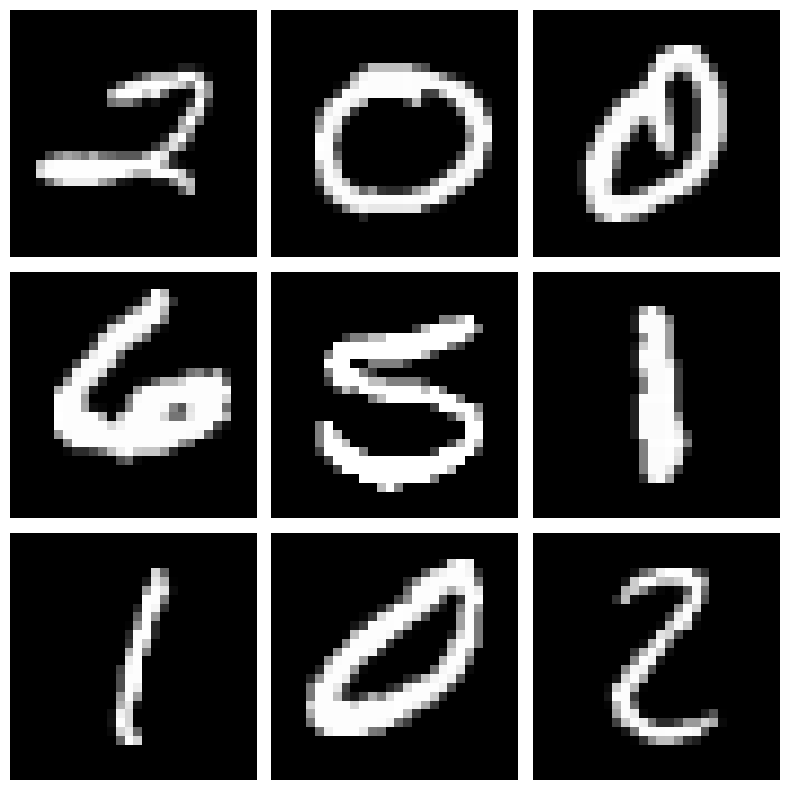

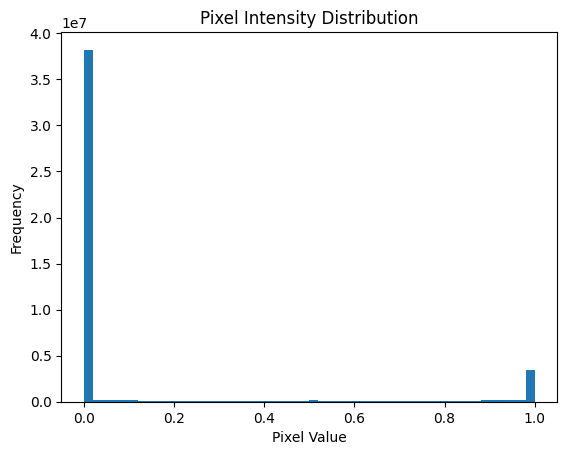

In [ ]:

import matplotlib.pyplot as plt
# Display sample images
fig, axes = plt.subplots(3, 3, figsize=(8,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(Xtrain_img[i][0], cmap='gray')  # Squeeze channel dimension
    ax.axis('off')
plt.tight_layout()
plt.show()

# Pixel intensity distribution
plt.hist(flattened.ravel(), bins=50)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()


In [8]:
# Find images with extreme brightness
brightest_idx = np.argmax(mean_per_image)
darkest_idx = np.argmin(mean_per_image)

print(f"Brightest image index: {brightest_idx} (mean: {mean_per_image[brightest_idx]:.1f})")
print(f"Darkest image index: {darkest_idx} (mean: {mean_per_image[darkest_idx]:.1f})")


Brightest image index: 50381 (mean: 0.4)
Darkest image index: 33002 (mean: 0.0)


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

def apply_standard_scaler(X_train=None, X_test=None):

    X_train_scaled = None
    X_test_scaled = None

    scaler = StandardScaler()
    if X_train is not None:
        X_train_scaled = scaler.fit_transform(X_train)
    
    if X_test is not None:
        X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled

def apply_pca(X_train_scaled, X_test_scaled=None, variance_threshold=0.95, loading_threshold=0.3, 
              plot_heatmap=True, plot_bar=True, plot_variance=True):
    
    data = pd.DataFrame(X_train_scaled)
    feature_names = data.columns
    data_scaled = data.values

    max_components = min(data_scaled.shape[0], data_scaled.shape[1])
    pca = PCA(n_components=max_components)
    pca.fit(data_scaled)
    
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.where(cumulative_variance >= variance_threshold)[0][0] + 1
    total_variance = cumulative_variance[n_components - 1]
    
    pca = PCA(n_components=n_components)
    pca.fit(data_scaled)
    
    loadings_df = pd.DataFrame(
        pca.components_.T,
        index=feature_names,
        columns=[f'PC{i+1}' for i in range(n_components)]
    )

    ## Simple way::
    # pca = PCA()
    # pca.fit(data_scaled)
    # cumsum = np.cumsum(pca.explained_variance_ratio_)
    # d = np.argmax(cumsum >= variance_threshold) + 1
    # n_components = d
    ## OR
    # pca = PCA(n_components=0.95)
    # X_reduced = pca.fit_transform(data_scaled)
    
    suggested_names = {}
    print(f"\nSelected {n_components} components to explain {total_variance*100:.2f}% of variance")
    for i, pc in enumerate(loadings_df.columns):
        dominant_feature = loadings_df[pc].abs().idxmax()
        max_loading = loadings_df[pc][dominant_feature]
        suggested_names[pc] = f"{dominant_feature}_Dominant (Loading: {max_loading:.3f})"
        
        pc_loadings = loadings_df[pc]
        dominant_cols = pc_loadings[np.abs(pc_loadings) > loading_threshold]
        if dominant_cols.empty:
            dominant_cols = pc_loadings[[pc_loadings.abs().idxmax()]]
        dominant_cols = dominant_cols.sort_values(key=abs, ascending=False)
        
        print(f"\nDominant Columns for {pc}:")
        for feature, loading in dominant_cols.items():
            print(f"- {feature}: Loading = {loading:.3f}, Absolute = {abs(loading):.3f}")
        print(f"PC{i+1}: Explains {pca.explained_variance_ratio_[i]*100:.2f}% of variance")
    
    if plot_heatmap:
        plt.figure(figsize=(12, 8))
        sns.heatmap(loadings_df, cmap='coolwarm', center=0, annot=True, fmt='.2f')
        plt.title('PCA Loadings: Feature Contributions to Principal Components')
        plt.xlabel('Principal Components')
        plt.ylabel('Features')
        plt.tight_layout()
        plt.show()
    
    if plot_bar:
        for pc in loadings_df.columns:
            plt.figure(figsize=(10, 6))
            loadings_df[pc].sort_values(ascending=False).plot(kind='bar')
            plt.title(f'Feature Loadings for {pc}')
            plt.xlabel('Features')
            plt.ylabel('Loading Value')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

    if plot_variance:
        max_components = len(pca.explained_variance_ratio_)
        plot_variance_charts(pca.explained_variance_ratio_, cumulative_variance, max_components)
    
    print("\nSuggested Names for Principal Components:")
    for pc, name in suggested_names.items():
        print(f"{pc}: {name}")
    
    X_train_pca = pca.transform(X_train_scaled)

    X_test_pca = None
    if X_test_scaled is not None:
        X_test_pca = pca.transform(X_test_scaled)
    explained_variance_ratio = pca.explained_variance_ratio_

    return X_train_pca, X_test_pca, explained_variance_ratio, cumulative_variance

def plot_variance_charts(explained_variance_ratio, cumulative_variance, max_components):
    # Truncate arrays to max_components to ensure matching lengths
    explained_variance_ratio = explained_variance_ratio[:max_components]
    cumulative_variance = cumulative_variance[:max_components]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar chart of individual variances
    pcs = [f'PC{i+1}' for i in range(len(explained_variance_ratio))]
    ax1.bar(pcs, explained_variance_ratio * 100)
    ax1.set_title('Variance Captured by Each Principal Component')
    ax1.set_xlabel('Principal Components')
    ax1.set_ylabel('Variance Explained (%)')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, axis='y')
    
    # Bar chart with cumulative variance
    ax2.bar(pcs, explained_variance_ratio * 100, label='Individual Variance')
    ax2.plot(pcs, cumulative_variance * 100, color='red', marker='o', linestyle='--', label='Cumulative Variance')
    ax2.set_title('Variance with Cumulative Variance Overlay')
    ax2.set_xlabel('Principal Components')
    ax2.set_ylabel('Variance Explained (%)')
    ax2.tick_params(axis='x', rotation=45)
    ax2.legend()
    ax2.grid(True, axis='y')
    
    plt.tight_layout()
    plt.show()

def apply_tsne(X_train_scaled, tsne_perplexity=30.0):
    
    tsne = TSNE(n_components=2, perplexity=tsne_perplexity, random_state=42, verbose=0)
    X_train_tsne = tsne.fit_transform(X_train_scaled)
    
    plt.figure(figsize=(10, 6))
    # scatter = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], cmap='viridis', s=50, alpha=0.6)
    scatter = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], cmap='tab10', s=10, alpha=0.6)
    plt.colorbar(label='Target Value')
    plt.title(f't-SNE of Training Data (Perplexity={tsne_perplexity})')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()
    
    return X_train_tsne

In [18]:
X_scaled_flat, _ = apply_standard_scaler(X_train=flattened)

print(f"Scaled data mean: {X_scaled_flat.mean():.2f}") 
print(f"Scaled data std: {X_scaled_flat.std():.2f}") 


Scaled data mean: -0.00
Scaled data std: 0.96


/var/folders/tw/l5tzs72d3dd0wms159v1b2980000gn/T/ipykernel_3099/1313409828.py:149: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], cmap='tab10', s=10, alpha=0.6)


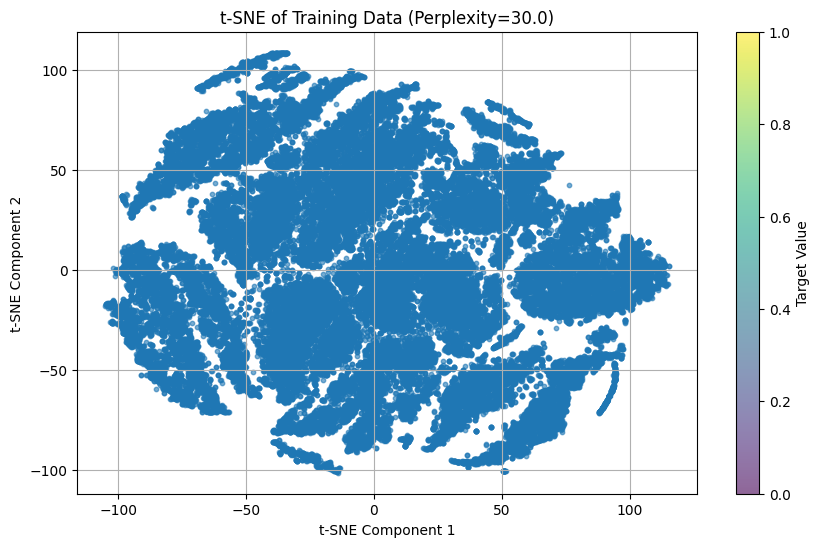

In [25]:
X_train_tsne = apply_tsne(X_scaled_flat)
# X_train_pca, X_test_pca, explained_variance_ratio, cumulative_variance = apply_pca(X_scaled_flat)

In [ ]:
# Libraries for clustering, modeling, visualization, dimensionality reduction, and I/O
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
from umap import UMAP
from skimage.feature import hog
import seaborn as sns
import joblib
import os

# 1. Load and preprocess dataset
image_dataset = np.load(local_image_dateset)  # Load pre-saved numpy array (shape: [n_samples, 1, 28, 28])
image_dataset = image_dataset.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
image_dataset = image_dataset.reshape(-1, 28, 28)  # Reshape for HOG feature extraction

# 2. Train-Validation Split
X_train, X_val = train_test_split(image_dataset, test_size=0.2, random_state=42)  # Use 20% of data for validation

# 3. HOG Feature Extractor (replaces CNN feature extractor)

# HOG Feature Extraction Function
def extract_hog_features(images):
    hog_features = []
    for img in images:
        feature = hog(img, orientations=9, pixels_per_cell=(4, 4), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
        hog_features.append(feature)
    return np.array(hog_features)

X_train_features = extract_hog_features(X_train)
X_val_features = extract_hog_features(X_val)

# 4. UMAP Dimensionality Reduction
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_val_scaled = scaler.transform(X_val_features)

umap = UMAP(n_components=10, random_state=42)
X_train_umap = umap.fit_transform(X_train_scaled)
X_val_umap = umap.transform(X_val_scaled)

joblib.dump(umap, 'umap_model.pkl')  # Save UMAP transformer for reuse

# PCA and UMAP Visualization
from sklearn.decomposition import PCA

# Evaluate and visualize explained variance by PCA
pca_full = PCA().fit(X_train_scaled)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.tight_layout()
plt.show()


# Helper function to plot 2D PCA embedding of clusters
def plot_pca_2d(X, labels, title):
    pca_2d = PCA(n_components=2, random_state=42)
    X_2d = pca_2d.fit_transform(X)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', s=5, alpha=0.6)
    plt.legend(*scatter.legend_elements(), title="Cluster")
    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Helper function to plot 2D UMAP embedding of clusters
def plot_umap_2d(X, labels, title):
    umap_2d = UMAP(n_components=2, random_state=42)
    X_2d = umap_2d.fit_transform(X)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', s=5, alpha=0.6)
    plt.legend(*scatter.legend_elements(), title="Cluster")
    plt.title(title)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 5. Compare Clustering: GMM vs KMeans

# Flatten image data for classifier use in clustering comparison
X_train_flat = X_train.reshape(len(X_train), -1)
X_val_flat = X_val.reshape(len(X_val), -1)

# Apply KMeans for comparison
kmeans = KMeans(n_clusters=10, n_init=20, max_iter=500, random_state=42)
y_train_kmeans = kmeans.fit_predict(X_train_umap)
y_val_kmeans = kmeans.predict(X_val_umap)

# Compute silhouette scores and adjusted rand scores

gmm = GaussianMixture(n_components=10, covariance_type='full', random_state=42)
y_train_gmm = gmm.fit_predict(X_train_umap)
y_val_gmm = gmm.predict(X_val_umap)
silhouette_kmeans = silhouette_score(X_train_umap, y_train_kmeans)
silhouette_gmm = silhouette_score(X_train_umap, y_train_gmm)

# To compare using labels, assign a dummy classifier for pseudo ground truth (unsupervised case workaround)
kmeans_dummy_clf = RandomForestClassifier(n_estimators=200, max_depth=25, random_state=42)
gmm_dummy_clf = RandomForestClassifier(n_estimators=200, max_depth=25, random_state=42)
kmeans_dummy_clf.fit(X_train_flat, y_train_kmeans)
gmm_dummy_clf.fit(X_train_flat, y_train_gmm)  # Moved after GMM definition to avoid NameError

y_val_pred_kmeans = kmeans_dummy_clf.predict(X_val_flat)
y_val_pred_gmm = gmm_dummy_clf.predict(X_val_flat)

ari_kmeans = adjusted_rand_score(y_val_kmeans, y_val_pred_kmeans)
ari_gmm = adjusted_rand_score(y_val_gmm, y_val_pred_gmm)
f1_kmeans = f1_score(y_val_kmeans, y_val_pred_kmeans, average='macro')
f1_gmm = f1_score(y_val_gmm, y_val_pred_gmm, average='macro')

print("Silhouette Score (KMeans):", silhouette_kmeans)
print("Silhouette Score (GMM):", silhouette_gmm)
print("Adjusted Rand Index (KMeans):", ari_kmeans)
print("Adjusted Rand Index (GMM):", ari_gmm)
print("Macro F1 Score (KMeans):", f1_kmeans)
print("Macro F1 Score (GMM):", f1_gmm)

# Visual comparison of clustering metrics
metrics = ['Silhouette Score', 'Adjusted Rand Index', 'Macro F1 Score']
kmeans_scores = [silhouette_kmeans, ari_kmeans, f1_kmeans]
gmm_scores = [silhouette_gmm, ari_gmm, f1_gmm]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, kmeans_scores, width, label='KMeans')
plt.bar(x + width/2, gmm_scores, width, label='GMM')
plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Comparison of Clustering Methods')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Visual comparison
plot_pca_2d(X_train_scaled, y_train_kmeans, "PCA - KMeans Clusters (Train)")
plot_umap_2d(X_train_umap, y_train_kmeans, "UMAP - KMeans Clusters (Train)")

plot_pca_2d(X_train_scaled, y_train_gmm, "PCA - GMM Clusters (Train)")
plot_umap_2d(X_train_umap, y_train_gmm, "UMAP - GMM Clusters (Train)")

# 6. Visualize cluster centroids
print('Visualize cluster centroids')
# Display representative images from a cluster
def show_cluster_examples(X, labels, cluster_id):
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(np.where(labels == cluster_id)[0][:10]):
        plt.subplot(1, 10, i+1)
        plt.imshow(X[idx], cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Cluster {cluster_id} Examples")
    plt.show()

for cid in range(10):
    show_cluster_examples(X_train, y_train_gmm, cid)


plt.figure(figsize=(8, 4))
sns.countplot(x=y_train_gmm, palette='tab10')
plt.title("Class Distribution Before SMOTE-Tomek")
plt.xlabel("Cluster Label")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# 8. Baseline Classification Before SMOTE

# Evaluate and visualize Silhouette Score before SMOTE
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train_flat, y_train_gmm)

clf_baseline = RandomForestClassifier(n_estimators=200, max_depth=25, random_state=42)
clf_baseline.fit(X_train_flat, y_train_gmm)
y_val_baseline = clf_baseline.predict(X_val_flat)

print("--- Evaluation Before SMOTE-Tomek ---")
print("Adjusted Rand Score:", adjusted_rand_score(y_val_gmm, y_val_baseline))
print("Macro F1 Score:", f1_score(y_val_gmm, y_val_baseline, average='macro'))
print("Classification Report:")
print(classification_report(y_val_gmm, y_val_baseline))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val_gmm, y_val_baseline), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix Before SMOTE")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Now apply SMOTE + TomekLink
print("Applying SMOTE + TomekLink...")

# 9. Manually or automatically map resampled cluster IDs to digit labels
# Set to True to enable manual entry, False for predefined mapping
# manual_mapping = False
# if manual_mapping:
#     cluster_to_digit = {}
#     for cid in np.unique(y_train_resampled):
#         indices = np.where(y_train_gmm == cid)[0][:20]
#         plt.figure(figsize=(20, 4))
#         for i, idx in enumerate(indices):
#             plt.subplot(2, 10, i + 1)
#             plt.imshow(X_train[idx], cmap='gray')
#             plt.axis('off')
#         plt.suptitle(f"Cluster {cid} Examples")
#         plt.show()

#         label = input(f"Enter the digit label (0–9) for Cluster {cid}: ")
#         cluster_to_digit[cid] = int(label)
# else:
#     # Default auto-mapping based on fixed label order
#     ordered_digits = [4, 3, 1, 5, 6, 7, 8, 0, 2, 9]
#     cluster_ids = sorted(np.unique(y_train_resampled))
#     cluster_to_digit = {cid: label for cid, label in zip(cluster_ids, ordered_digits)}

# --- FIXED SECTION START: SAN ---
manual_mapping = False
if manual_mapping:
    cluster_to_digit = {}
    for cid in np.unique(y_train_resampled):
        indices = np.where(y_train_resampled == cid)[0][:20]  # <-- FIXED: Use correct indices from resampled labels
        plt.figure(figsize=(20, 4))
        for i, idx in enumerate(indices):
            plt.subplot(2, 10, i + 1)
            plt.imshow(X_train_resampled[idx].reshape(28, 28), cmap='gray')  # <-- FIXED: Show correct image
            plt.axis('off')
        plt.suptitle(f"Cluster {cid} Examples")
        plt.show()

        label = input(f"Enter the digit label (0–9) for Cluster {cid}: ")
        cluster_to_digit[cid] = int(label)
else:
    # Default auto-mapping based on fixed label order
    ordered_digits = [4, 3, 1, 5, 6, 7, 8, 0, 2, 9]
    cluster_ids = sorted(np.unique(y_train_resampled))
    cluster_to_digit = {cid: label for cid, label in zip(cluster_ids, ordered_digits)}

# --- FIXED SECTION END: SAN ---

print("Cluster to Digit Mapping Preview:")
for k, v in cluster_to_digit.items():
    print(f"Cluster {k} → Digit {v}")

print("Mapping saved to 'cluster_to_digit_mapping.pkl'")

y_train_labeled = np.array([cluster_to_digit.get(cluster, -1) for cluster in y_train_resampled])
y_val_labeled = np.array([cluster_to_digit.get(cluster, -1) for cluster in y_val_gmm])

plt.figure(figsize=(8, 4))
sns.countplot(x=y_train_resampled, palette='tab10')
plt.title("Class Distribution After SMOTE-Tomek")
plt.xlabel("Cluster Label")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Show 10 samples per mapped label
for label in sorted(set(cluster_to_digit.values())):
    indices = np.where(y_train_labeled == label)[0][:10]
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(indices):
        plt.subplot(1, 10, i + 1)
        plt.imshow(X_train_resampled[idx].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Mapped Label {label} Examples")
    plt.tight_layout()
    plt.show()
  
# Recompute features from SMOTE-resampled data for fair classifier comparison
X_train_resampled_images = X_train_resampled.reshape(-1, 28, 28)
X_train_resampled_features = extract_hog_features(X_train_resampled_images)
X_train_resampled_scaled = scaler.transform(X_train_resampled_features)
X_train_resampled_umap = umap.transform(X_train_resampled_scaled)

# Evaluation function used below
def evaluate_model(y_true, y_pred, title):
    print(f"--- {title} ---")
    print("Adjusted Rand Score:", adjusted_rand_score(y_true, y_pred))
    print("Macro F1 Score:", f1_score(y_true, y_pred, average='macro'))
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {title}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# 12. Evaluation

# Function to compare classifiers and explain the selection basis

def compare_classifiers():
    print("Comparing classifiers trained on different feature sets:")

    clf_raw = RandomForestClassifier(n_estimators=200, max_depth=25, random_state=42)
    clf_raw.fit(X_train_resampled, y_train_labeled)
    y_val_pred_raw = clf_raw.predict(X_val_flat)
    evaluate_model(y_val_labeled, y_val_pred_raw, "Classifier on Raw Flattened Pixels")

    clf_hog = RandomForestClassifier(n_estimators=200, max_depth=25, random_state=42)
    clf_hog.fit(X_train_resampled_scaled, y_train_labeled)
    y_val_pred_hog = clf_hog.predict(X_val_scaled)
    evaluate_model(y_val_labeled, y_val_pred_hog, "Classifier on HOG Features (Scaled)")

    clf_umap = RandomForestClassifier(n_estimators=200, max_depth=25, random_state=42)
    clf_umap.fit(X_train_resampled_umap, y_train_labeled)
    y_val_pred_umap = clf_umap.predict(X_val_umap)
    evaluate_model(y_val_labeled, y_val_pred_umap, "Classifier on UMAP-Reduced Features")

    classifier_metrics = ['Adjusted Rand Score', 'Macro F1 Score']
    raw_scores = [adjusted_rand_score(y_val_labeled, y_val_pred_raw), f1_score(y_val_labeled, y_val_pred_raw, average='macro')]
    hog_scores = [adjusted_rand_score(y_val_labeled, y_val_pred_hog), f1_score(y_val_labeled, y_val_pred_hog, average='macro')]
    umap_scores = [adjusted_rand_score(y_val_labeled, y_val_pred_umap), f1_score(y_val_labeled, y_val_pred_umap, average='macro')]

    x = np.arange(len(classifier_metrics))
    width = 0.25

    plt.figure(figsize=(10, 6))
    plt.bar(x - width, raw_scores, width, label='Raw Pixels')
    plt.bar(x, hog_scores, width, label='HOG Features')
    plt.bar(x + width, umap_scores, width, label='UMAP Features')
    plt.xticks(x, classifier_metrics)
    plt.ylabel('Score')
    plt.title('Classifier Performance by Feature Type')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("Classifier selection is based on maximum values of evaluation metrics:")
    print(f"UMAP Adjusted Rand Score: {umap_scores[0]:.4f}, Macro F1 Score: {umap_scores[1]:.4f}")
    print("The model trained on UMAP features being saved as rf_classifier.pkl")

compare_classifiers()

# 12B. Final Classification Pipeline using HOG + UMAP features

# Final model (best performing) - UMAP features
final_clf = RandomForestClassifier(n_estimators=200, max_depth=25, random_state=42)
final_clf.fit(X_train_resampled_umap, y_train_labeled)
y_val_final = final_clf.predict(X_val_umap)
evaluate_model(y_val_labeled, y_val_final, "Final Classifier (UMAP Features)")

# 13. Save All Trained Models
joblib.dump(cluster_to_digit, 'cluster_to_digit_mapping.pkl')
joblib.dump(gmm, 'gmm_cluster_model.pkl')
joblib.dump(final_clf, 'rf_umap_classifier.pkl')
joblib.dump(scaler, 'hog_scaler.pkl')
print('All Trianed Models saved')

# 14. Reusable Prediction Function
def predict_clusters(
    npy_file_path: str,
    umap_model_path: str = "umap_model.pkl",
    gmm_model_path: str = "gmm_cluster_model.pkl",
    classifier_model_path: str = "rf_umap_classifier.pkl",
    scaler_model_path: str = "hog_scaler.pkl",
    cluster_to_digit: dict = None  # Optional mapping, will load from file if not provided
):
    if not os.path.exists(npy_file_path):
        raise FileNotFoundError(f"File not found: {npy_file_path}")

    image_array = np.load(npy_file_path)

    if image_array.ndim == 4:
        image_array = image_array.reshape(-1, 28, 28)
    elif image_array.ndim == 3:
        pass
    else:
        raise ValueError("Input shape must be (n_samples, 1, 28, 28) or (n_samples, 28, 28)")

    image_array = image_array.astype('float32') / 255.0

    def extract_hog(images):
        features = []
        for img in images:
            feat = hog(img, orientations=9, pixels_per_cell=(4, 4), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
            features.append(feat)
        return np.array(features)

    hog_features = extract_hog(image_array)
    scaler = joblib.load(scaler_model_path)
    hog_features_scaled = scaler.transform(hog_features)

    umap_model = joblib.load(umap_model_path)
    reduced_features = umap_model.transform(hog_features_scaled)

    gmm_model = joblib.load(gmm_model_path)
    classifier_model = joblib.load(classifier_model_path)

    results = {}
    gmm_labels = gmm_model.predict(reduced_features)
    # Classifier was trained on UMAP-reduced HOG features
    classifier_labels = classifier_model.predict(reduced_features)

    # Optional manual remapping of cluster labels
    if cluster_to_digit is None:
        if os.path.exists("cluster_to_digit_mapping.pkl"):
            cluster_to_digit = joblib.load("cluster_to_digit_mapping.pkl")
        else:
            raise FileNotFoundError("cluster_to_digit_mapping.pkl not found and no mapping provided.")

    if cluster_to_digit:
        gmm_labels = np.array([cluster_to_digit.get(lbl, -1) for lbl in gmm_labels])

    results['gmm_labels'] = gmm_labels
    results['classifier_labels'] = classifier_labels

    return results
